## Youtube

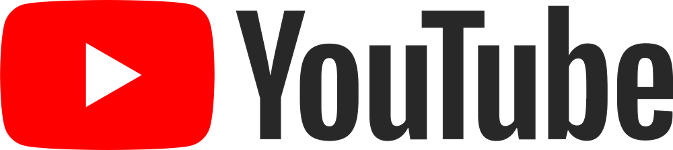

### Getting Developer Key

* follow this [video tutorial](https://www.youtube.com/watch?v=pP4zvduVAqo)
* or text instructions at https://developers.google.com/youtube/v3/getting-started

### Getting Started

* Youtube provides 1 million credits free per day
* Usual operations cost between 1 and 10 credits, leading to ca. 100k api calls per day
* [API Documentation](https://developers.google.com/youtube/v3/docs/videos/list)

In [1]:
import os

from dotenv import load_dotenv
load_dotenv()

DEVELOPER_KEY = os.environ['YOUTUBE_KEY']

### Utility Functions

We need some utility functions to wrap the Youtube API.
The API has lots of error cases, timeouts, recoverable errors, etc. that we need to take care of.

In [2]:
import logging
from apiclient.discovery import build
from googleapiclient.errors import HttpError

logging.getLogger('googleapicliet.discovery_cache').setLevel(logging.ERROR)

YOUTUBE_API_SERVICE_NAME = 'youtube'
YOUTUBE_API_VERSION = 'v3'

youtube = build(YOUTUBE_API_SERVICE_NAME,
                YOUTUBE_API_VERSION,
                developerKey=DEVELOPER_KEY,
                cache_discovery=False)

def runner(func, max_results=50, perPage=50, iterate=True, **kwargs):
    """ utility function for pagination, etc. """
    results_rem = max_results

    nexttok = None
    while results_rem > 0:
        kwargs = dict(kwargs,
                      pageToken=nexttok,
                      maxResults=perPage)

        try:
            search_response = func(**kwargs).execute()
        except HttpError as e:
            logging.warning('content: %r', e.content)
            break

        for search_result in search_response.get('items', []):
            yield search_result

        nexttok = search_response.get('nextPageToken')
        if nexttok is None or not iterate:
            break
        results_rem -= perPage


def search_videos(q, max_results=200, order='relevance'):
    """
    search youtube videos
    order: date, rating, relevance, title, videoCount, viewCount
    """
    return runner(
        youtube.search().list,
        max_results=max_results,
        q=q,
        type='video',
        order=order,
        part='id,snippet',
    )

def get_videos(video_ids):
    """ get details for comma-separated video_ids """
    return runner(
        youtube.videos().list,
        part='id,snippet,topicDetails',
        id=video_ids)

### 200 Machine Learning videos

Let's find the 200 most recent videos about "machine learning".

In [3]:
import json

res = list(search_videos('machine learning', max_results=200, order='date'))

video_id = res[198]['id']['videoId']
detailed = list(get_videos(video_id))
print(json.dumps(detailed, indent=4))

[
    {
        "kind": "youtube#video",
        "etag": "\"p4VTdlkQv3HQeTEaXgvLePAydmU/dezr71md6n_ajuFyFT7bxgzDmLY\"",
        "id": "JdFw-kKfBzw",
        "snippet": {
            "publishedAt": "2018-12-11T13:59:51.000Z",
            "channelId": "UCgdHSFcXvkN6O3NXvif0-pA",
            "title": "Unsupervised Machine Learning | Introduction to Machine Learning, Part 2",
            "description": "Try machine learning now:\n- Train a machine learning model right in your browser: http://bit.ly/2QCnU6X\n- Get a free machine learning trial: http://bit.ly/2QKxhBX\n\nGet an overview of unsupervised machine learning. Unsupervised Machine Learning looks for patterns in datasets that don\u2019t have labeled responses. \n\n- MATLAB for Machine Learning: http://bit.ly/2QIDlum\n- Machine Learning with MATLAB eBook: http://bit.ly/2QBFiZO\n\nYou\u2019d use this technique when you want to explore your data but don\u2019t yet have a specific goal, or you\u2019re not sure what information the data c

### Video Comments

Let's fetch comments for the above video, even though it is a very recent upload.

In [4]:
def video_comments(videoId, q=None, max_results=50):
    """ fetch comments for video `videoId` """
    return runner(
        youtube.commentThreads().list,
        max_results=max_results,
        part='id,replies,snippet',
        order='relevance',
        videoId=videoId,
        searchTerms=q,
        textFormat='plainText'
    )

comments = list(video_comments(video_id))
print(json.dumps(comments, indent=4))

[
    {
        "kind": "youtube#commentThread",
        "etag": "\"p4VTdlkQv3HQeTEaXgvLePAydmU/JnN3DWtqPe78nkPNJYo41oL51rk\"",
        "id": "UgxDmWGY2O_g81D2Lwp4AaABAg",
        "snippet": {
            "videoId": "JdFw-kKfBzw",
            "topLevelComment": {
                "kind": "youtube#comment",
                "etag": "\"p4VTdlkQv3HQeTEaXgvLePAydmU/yimQqgeEUxR9hX3947Pl_3ZwGFE\"",
                "id": "UgxDmWGY2O_g81D2Lwp4AaABAg",
                "snippet": {
                    "authorDisplayName": "Lion",
                    "authorProfileImageUrl": "https://yt3.ggpht.com/a/AGF-l7_PSnBJXOWQxwv-6FUucNftTS-6KMvQt_ebiw=s48-c-k-c0xffffffff-no-rj-mo",
                    "authorChannelUrl": "http://www.youtube.com/channel/UCzDVttyWyaGmeRwB8clp8tQ",
                    "authorChannelId": {
                        "value": "UCzDVttyWyaGmeRwB8clp8tQ"
                    },
                    "videoId": "JdFw-kKfBzw",
                    "textDisplay": "Awesome",
                 

## Other Capabilities

* find related videos
* fetch channel information and videos
* fetch closed captions
* given oauth permissions also possible to fetch user history, likes, subscriptions, etc.